# **RICE PLANT DISEASE DETECTION USING INCEPTIONV3**

In [1]:
import os, glob
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.layers import concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam


In [3]:
labels_diction = {
    'Bacterial leaf blight': 0,
    'Brown spot': 1,
    'Leaf smut': 2,

}


In [5]:
data_dir = '/content/drive/MyDrive/rice_leaf_diseases'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/MyDrive/DataSets/rice_leaf_diseases'

X = []
y = []
for folder in os.listdir(data_dir):
    label = labels_diction[folder]
    for image in os.listdir(os.path.join(data_dir, folder)):
        image_path = os.path.join(data_dir, folder, image)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (227, 227))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [7]:
# Data augmentation
#datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X, y, batch_size=32)


In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False


In [10]:
#hidden layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels_diction), activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=output)

In [12]:
from keras.optimizers import Adam

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)  # You might need other augmentations here if used during training
test_generator =test_datagen.flow(X, y, batch_size=32)

In [25]:
# Training the model
history = model.fit(
    datagen.flow(X, y, batch_size=32),
    epochs=20
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9108 - loss: 0.1836
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9529 - loss: 0.1818
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9792 - loss: 0.1058
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9413 - loss: 0.2315
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9267 - loss: 0.1814
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9944 - loss: 0.0836
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9631 - loss: 0.1328
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9256 - loss: 0.1693
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9480 - loss: 0.1335
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9892 - loss: 0.0952
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8756 - loss: 0.1962
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9775 - loss: 0.0981


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9798 - loss: 0.0605
Test loss: 0.06031488627195358
Test accuracy: 0.9833333492279053


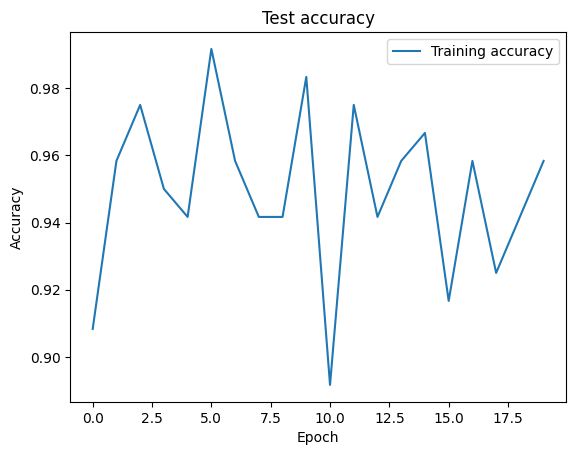

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)  # Assuming you have a separate test generator
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

# Plot accuracy graph
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Saving the model
model.save('rice_leaf_diseases_model_inceptionv3.h5')

In [22]:
# Loading the model
new_model = tf.keras.models.load_model('rice_leaf_diseases_model_inceptionv3.h5')

In [23]:
# Predicting on a new image
import PIL
image_path = '/content/drive/MyDrive/DataSets/rice_leaf_diseases/Brown spot/DSC_0100.jpg'
test_image = PIL.Image.open(image_path)
resized_image = test_image.resize((227, 227))
resized_image = np.array(resized_image) / 255.0
resized_image = resized_image[np.newaxis, ...]
prediction = new_model.predict(resized_image)
predicted_class_index = np.argmax(prediction)
#Print the predicted class index and check it
print('Predicted class index:', predicted_class_index)

# Map predicted class index to the actual label using the dictionary
predicted_label = {v: k for k, v in labels_diction.items()}.get(predicted_class_index)
print('Predicted label:', predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class index: 1
Predicted label: Brown spot
